In [1]:
!pip install seaborn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
sns.set_palette('pastel') 

from tensorflow.keras.utils import load_img
from sklearn.model_selection import train_test_split
import random
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# **Problem Introduction**
Accurate identification of metastasis in cancer patients is of paramount importance in determining appropriate treatment strategies and improving overall patient outcomes. Histopathology, a cornerstone of cancer diagnostics, involves the microscopic examination of tissue samples for the presence of abnormalities at the cellular level. It provides invaluable insights into the progression and characteristics of tumors.


<img src="https://my.clevelandclinic.org/-/scassets/images/org/health/articles/22213-metastatic-cancer" alt="Metastatic Cancer" style="width:500px;"/>

***(Clinic, 2021)***

Histopathological images, captured at high magnification, contain intricate details about cell morphology and tissue architecture. Analyzing these images manually is a time-consuming and error-prone task. Therefore, the integration of computational techniques, particularly deep learning, has emerged as a powerful tool for automating the detection of metastatic lesions.

In [3]:
#Read the training data into a DataFrame
df_train = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")

#Check dimensions of the data
dim = df_train.shape
print(f"There are {dim[1]} columns in the DataFrame which are {df_train.columns.to_list()}", 
      f"and there are {dim[0]} rows")

There are 2 columns in the DataFrame which are ['id', 'label'] and there are 220025 rows


In [4]:
#The data of the training photos is not contained in the DataFrame, instead, the DataFrame
#includes the id and the label for each one.
df_train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


The image is 96 px tall and 96 px wide


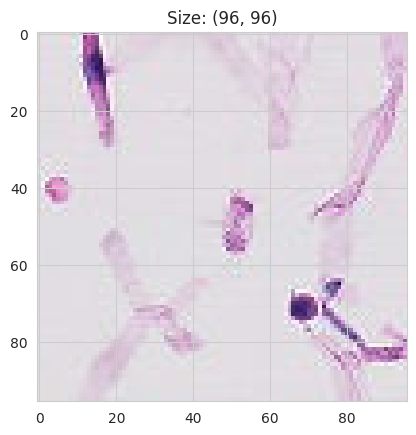

In [5]:
#The images can be accesed by using one route of the "id" column of our DataFrame
sample = random.choice(df_train["id"])
#Load image
image = load_img(f"/kaggle/input/histopathologic-cancer-detection/train/{sample}.tif")
img_size = image.size

plt.title(f"Size: {img_size}")
plt.imshow(image)
print(f"The image is {img_size[0]} px tall and {img_size[1]} px wide")

# **Exploratory Data Analysis (EDA)**

In [6]:
#There is no null values in the DataFrame
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [7]:
#Check all the avaiable images
filenames = os.listdir("/kaggle/input/histopathologic-cancer-detection/train/")

#Check coincidences and missing images
mask = (df_train["id"] + ".tif").isin(filenames)

print(f"There are {mask.sum()} coincidences and {(~mask).sum()} missing images")

There are 220025 coincidences and 0 missing images


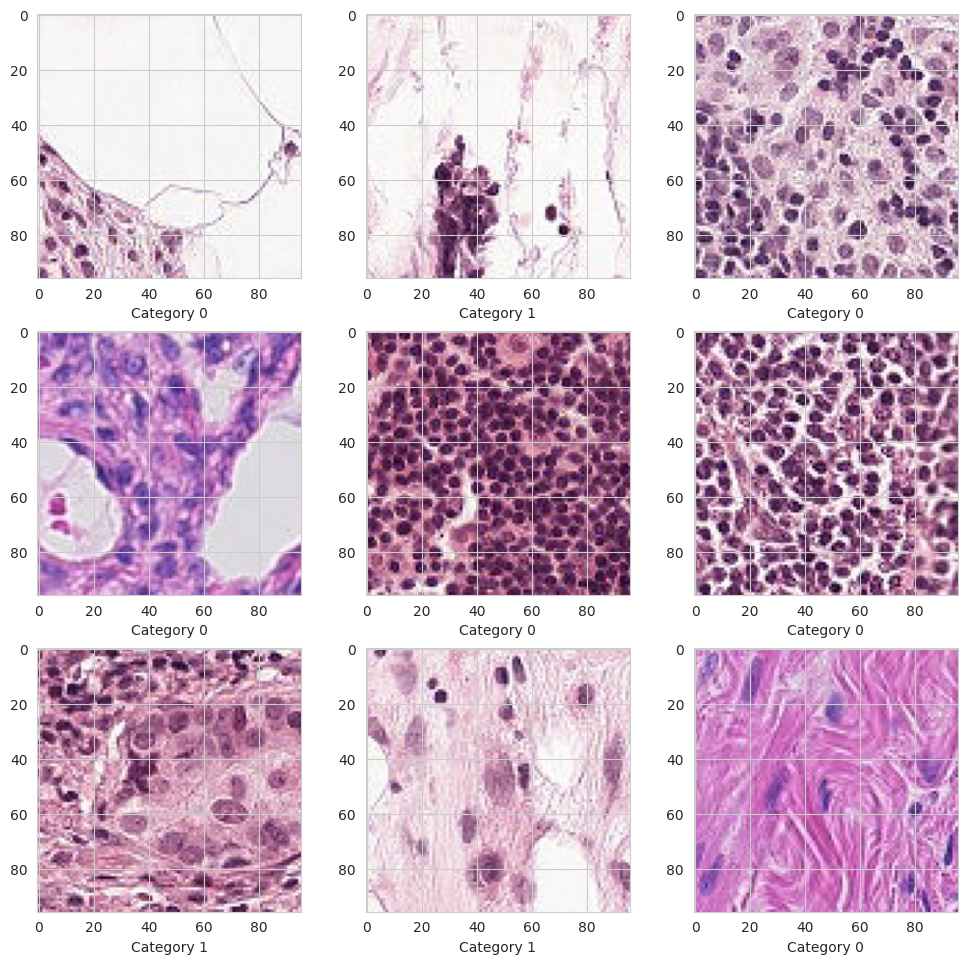

In [8]:
#Plot 9 sample images and their label
sample_test = df_train.head(9)
route = '/kaggle/input/histopathologic-cancer-detection/train/'

plt.figure(figsize=(12, 24))

#Iterate trough rows and plot the images
for index, row in sample_test.iterrows():
    filename = row['id']
    category = row['label']
    
    img = load_img(route + filename + ".tif")
    
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(f"Category {category}")

#Show images
plt.show()

There are 89117 values with label 1 and 130908 with label 0


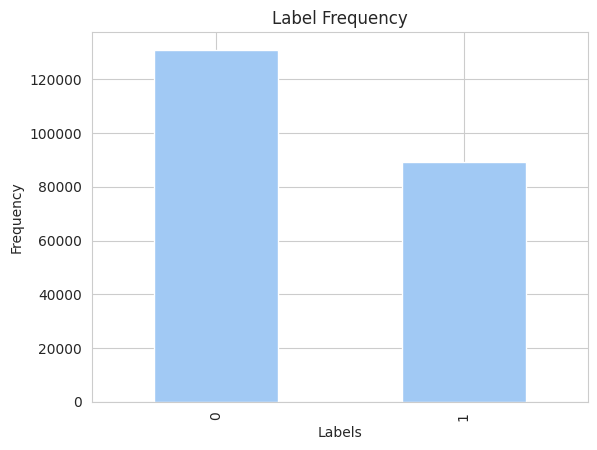

In [9]:
#Plot frequency of each label
freq = df_train["label"].value_counts()
freq.plot.bar()

plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Label Frequency')

print(f"There are {freq[1]} values with label 1 and {freq[0]} with label 0")

In [10]:
#Change the id of the image for the directory that contains it
input_col = "/kaggle/input/histopathologic-cancer-detection/train/"
df_train["id"] = input_col + df_train["id"] + ".tif"

#Divide data into X and y
y_train = df_train["label"]
X_train = df_train.drop(columns = "label")

# **Model Architecture**

In [11]:
import tensorflow as tf

In [12]:
#Constants definition
IMAGE_WIDTH = 96
IMAGE_HEIGHT = 96
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

In [13]:
#Rename classnames to strings to avoid errors from the Generators
df_train["label"] = df_train["label"].replace({0: "N", 1: "P"})

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Define Image Data Generator rescaling the pixels to a float between 0 and 1
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3
)

#Train flow from DataFrame
train_generator = train_datagen.flow_from_dataframe(
    dataframe = df_train,
    x_col = 'id',
    y_col = 'label',
    subset = 'training',
    target_size = IMAGE_SIZE,
    batch_size = 64,
    class_mode = 'binary'
)

#Validation flow from DataFrame
validation_generator = train_datagen.flow_from_dataframe(
    dataframe = df_train,
    x_col = 'id',
    y_col = 'label',
    subset ='validation',
    target_size = IMAGE_SIZE,
    batch_size = 64,
    class_mode = 'binary'
)

Found 154018 validated image filenames belonging to 2 classes.
Found 66007 validated image filenames belonging to 2 classes.


In [14]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras import metrics

#Number of filters by layer
FILTERS_1 = 32
FILTERS_2 = 64
FILTERS_3 = 128

model = Sequential()

#We will use a set of convolution layers with BatchNormalization to prevent overfitting and 
#increase generalization, followed by a MaxPooling to reduce the number of parameters and 
#decrease the training time and complexity. Aditionally, we will be using Dropout for similar
#reasons that the BatchNormalization.
model.add(Conv2D(FILTERS_1, (3, 3), padding="same", activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(Conv2D(FILTERS_1, (3, 3), padding="same", activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=3))
model.add(Dropout(0.25))

model.add(Conv2D(FILTERS_2, (3, 3), padding="same", activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(FILTERS_2, (3, 3), padding="same", activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=3))
model.add(Dropout(0.25))

model.add(Conv2D(FILTERS_3, (3, 3), padding="same", activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(FILTERS_3, (3, 3), padding="same", activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(FILTERS_3, (3, 3), padding="same", activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=3))
model.add(Dropout(0.25))

#We use a fully conected layer just after the flatten layer with a Dropout rate of .3
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.3))

#Finally, the last layer contains an only neuron with the sigmoid activation function for 
#binary classification
model.add(Dense(1, activation = 'sigmoid'))

#We use the Adam optimizer and the binary crossentropy loss function. Additionally, we evaluate 
#the model's performance using accuracy and the area under the ROC curve (AUC-ROC) metrics.
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='binary_crossentropy', metrics=['accuracy', metrics.AUC()])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 96, 96, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                        

**Why do we prioritize ROC-AUC over accuracy?**

The utilization of the area under the ROC curve (ROC-AUC) aims to establish a correlation between the number of "True Positives" (TPR) and the number of "False Positives" (FPR). The objective is to maximize TPR while minimizing the False Negative Rate (FNR).

<img src="https://www.oreilly.com/api/v2/epubs/9781838824914/files/assets/bb8832b2-2521-4823-b658-e1b62c928f99.png" alt="TPR Formula" style="width:500px;"/>

<img src="https://www.oreilly.com/api/v2/epubs/9781838824914/files/assets/9a3b7842-92a1-42a1-a859-3314c28e4fd7.png" alt="FPR Formula" style="width:500px;"/>

***(O'REILLY, 2021)***

In the medical field, this consideration significantly outweighs a simple accuracy score. By employing this metric, the intention is to maximize the "True Positive Rate," ensuring that even if some "Negatives" are misclassified as "Positives," and accuracy marginally decreases, patients testing positive for a particular disease are correctly identified, leading to timely and appropriate treatment.

# First five epochs

The training will be conducted in increments of three epochs for each iteration.

In [38]:
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint

#Definition of the custom scheduler that reduce the learning rate after the second epoch
def scheduler(epoch):
    if epoch < 3:
        return 0.001
    else:
        return 0.001 * (0.5 ** (epoch // 3))

lr_scheduler = LearningRateScheduler(scheduler)

#Definition of step sizes
STEP_SIZE_TRAIN = train_generator.n // 128
STEP_SIZE_VALID = validation_generator.n // 128

#Definition of a checkpoint that monitors the value of val_loss and restore the best model
checkpoint = ModelCheckpoint('BestModel.h5', 
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min',
                             verbose=1) 

#Early stopping that stops the training if the val_loss don´t seem to improve
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

#Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch = STEP_SIZE_TRAIN,
    epochs = 5,
    validation_data = validation_generator,
    validation_steps = STEP_SIZE_VALID,
    callbacks = [checkpoint, early_stopping])

Epoch 1/5


2023-11-08 06:36:04.495635: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/dropout_20/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1203/1203 [==============================] - ETA: 0s - loss: 0.4278 - accuracy: 0.8173 - auc_5: 0.8826
Epoch 1: val_loss improved from inf to 1.42225, saving model to BestModel.h5
1203/1203 [==============================] - 180s 144ms/step - loss: 0.4278 - accuracy: 0.8173 - auc_5: 0.8826 - val_loss: 1.4222 - val_accuracy: 0.6856 - val_auc_5: 0.6495
Epoch 2/5
1203/1203 [==============================] - ETA: 0s - loss: 0.3557 - accuracy: 0.8463 - auc_5: 0.9184
Epoch 2: val_loss improved from 1.42225 to 0.45028, saving model to BestModel.h5
1203/1203 [==============================] - 166s 138ms/step - loss: 0.3557 - accuracy: 0.8463 - auc_5: 0.9184 - val_loss: 0.4503 - val_accuracy: 0.8279 - val_auc_5: 0.8910
Epoch 3/5
1203/1203 [==============================] - ETA: 0s - loss: 0.3373 - accuracy: 0.8569 - auc_5: 0.9269
Epoch 3: val_loss did not improve from 0.45028
1203/1203 [==============================] - 159s 132ms/step - loss: 0.3373 - accuracy: 0.8569 - auc_5: 0.9269 - val_los

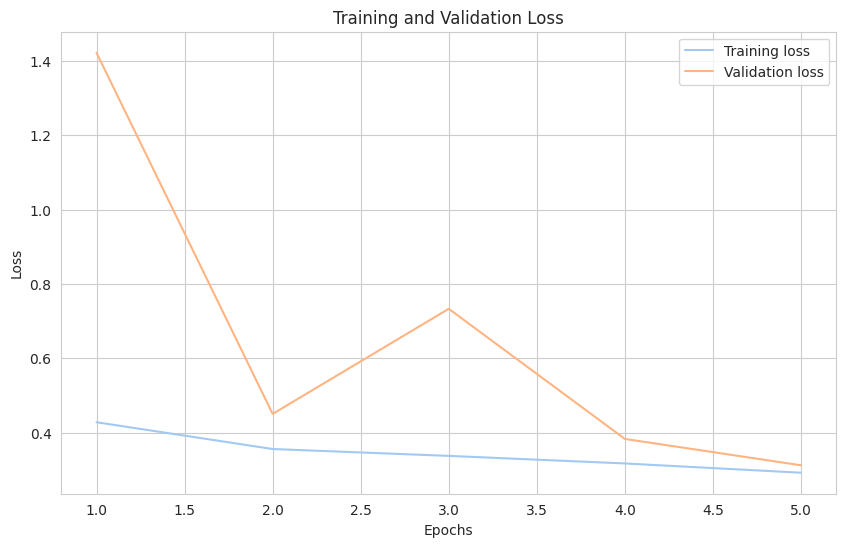

In [39]:
#Model plot of the training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
h = pd.DataFrame(history.history)
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The training had a little overshoot at the third epoch, but stabilizes right after in the fourth epoch. The values of the training and loss are very similar by the fifth epoch.

# Second five epochs


In [40]:
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint

#Definition of the custom scheduler that reduce the learning rate after the second epoch
def scheduler(epoch):
    n_epoch = epoch + 5
    if n_epoch < 3:
        return 0.001
    else:
        return 0.001 * (0.5 ** (n_epoch // 3))

lr_scheduler = LearningRateScheduler(scheduler)

#Definition of step sizes
STEP_SIZE_TRAIN = train_generator.n // 128
STEP_SIZE_VALID = validation_generator.n // 128

#Definition of a checkpoint that monitors the value of val_loss and restore the best model
checkpoint = ModelCheckpoint('BestModel_2.h5', 
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min',
                             verbose=1) 

#Early stopping that stops the training if the val_loss don´t seem to improve
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

#Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch = STEP_SIZE_TRAIN,
    epochs = 5,
    validation_data = validation_generator,
    validation_steps = STEP_SIZE_VALID,
    callbacks = [checkpoint, early_stopping])

Epoch 1/5
1203/1203 [==============================] - ETA: 0s - loss: 0.2678 - accuracy: 0.8919 - auc_5: 0.9535
Epoch 1: val_loss improved from inf to 0.50358, saving model to BestModel_2.h5
1203/1203 [==============================] - 164s 136ms/step - loss: 0.2678 - accuracy: 0.8919 - auc_5: 0.9535 - val_loss: 0.5036 - val_accuracy: 0.8153 - val_auc_5: 0.9010
Epoch 2/5
1203/1203 [==============================] - ETA: 0s - loss: 0.2542 - accuracy: 0.8983 - auc_5: 0.9581
Epoch 2: val_loss improved from 0.50358 to 0.39272, saving model to BestModel_2.h5
1203/1203 [==============================] - 158s 132ms/step - loss: 0.2542 - accuracy: 0.8983 - auc_5: 0.9581 - val_loss: 0.3927 - val_accuracy: 0.8289 - val_auc_5: 0.9085
Epoch 3/5
1203/1203 [==============================] - ETA: 0s - loss: 0.2431 - accuracy: 0.9036 - auc_5: 0.9612
Epoch 3: val_loss improved from 0.39272 to 0.25309, saving model to BestModel_2.h5
1203/1203 [==============================] - 154s 128ms/step - loss: 0

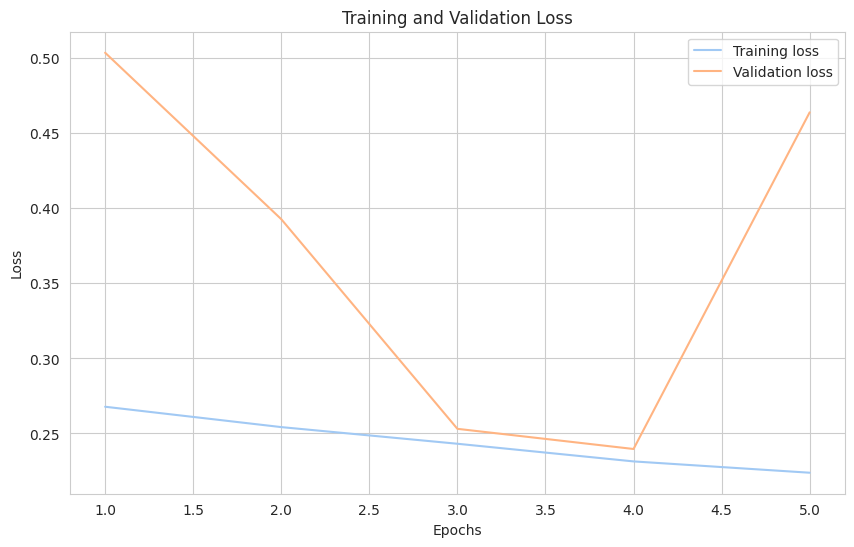

In [41]:
#Model plot of the training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
h = pd.DataFrame(history.history)
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The second iteration had a lot of overshoot but in the third and fourth epochs converged well and improved the scores of the past iteration.

# Third five epochs


In [42]:
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint

#Definition of the custom scheduler that reduce the learning rate after the second epoch
def scheduler(epoch):
    n_epoch = epoch + 10
    if n_epoch < 3:
        return 0.001
    else:
        return 0.001 * (0.5 ** (n_epoch // 3))

lr_scheduler = LearningRateScheduler(scheduler)

#Definition of step sizes
STEP_SIZE_TRAIN = train_generator.n // 128
STEP_SIZE_VALID = validation_generator.n // 128

#Definition of a checkpoint that monitors the value of val_loss and restore the best model
checkpoint = ModelCheckpoint('BestModel_3.h5', 
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min',
                             verbose=1) 

#Early stopping that stops the training if the val_loss don´t seem to improve
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

#Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch = STEP_SIZE_TRAIN,
    epochs = 5,
    validation_data = validation_generator,
    validation_steps = STEP_SIZE_VALID,
    callbacks = [checkpoint, early_stopping])

Epoch 1/5
1203/1203 [==============================] - ETA: 0s - loss: 0.2185 - accuracy: 0.9140 - auc_5: 0.9688
Epoch 1: val_loss improved from inf to 0.44804, saving model to BestModel_3.h5
1203/1203 [==============================] - 189s 157ms/step - loss: 0.2185 - accuracy: 0.9140 - auc_5: 0.9688 - val_loss: 0.4480 - val_accuracy: 0.8229 - val_auc_5: 0.8910
Epoch 2/5
1203/1203 [==============================] - ETA: 0s - loss: 0.2076 - accuracy: 0.9187 - auc_5: 0.9719
Epoch 2: val_loss improved from 0.44804 to 0.27608, saving model to BestModel_3.h5
1203/1203 [==============================] - 192s 160ms/step - loss: 0.2076 - accuracy: 0.9187 - auc_5: 0.9719 - val_loss: 0.2761 - val_accuracy: 0.8990 - val_auc_5: 0.9614
Epoch 3/5
1203/1203 [==============================] - ETA: 0s - loss: 0.2036 - accuracy: 0.9215 - auc_5: 0.9729
Epoch 3: val_loss did not improve from 0.27608
1203/1203 [==============================] - 177s 147ms/step - loss: 0.2036 - accuracy: 0.9215 - auc_5: 0.

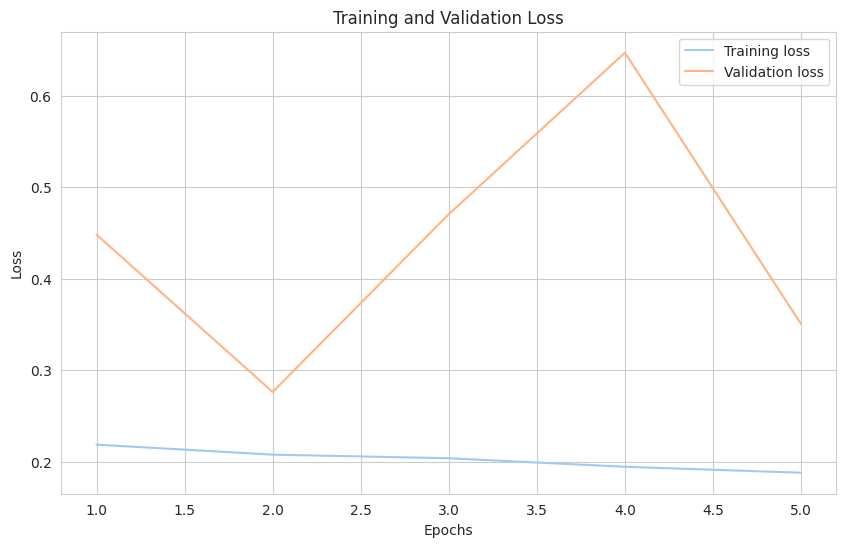

In [43]:
#Model plot of the training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
h = pd.DataFrame(history.history)
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The third iteration didn't converged well and had a lot of noise, that´s why we'll be using the weights obtained on the fourth epoch from the second iteration.

# Analysis and results

In [15]:
#As we observed in the three plots, the best model was obtained during the second iteration,
#so we load the weights into our model.
model.load_weights("/kaggle/working/BestModel_2.h5")

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Generator of test data
train_datagen = ImageDataGenerator(
    rescale=1./255,
)

#Test flow from DataFrame
train_generator = train_datagen.flow_from_dataframe(
    dataframe = df_train,
    x_col = 'id',
    y_col = None,
    target_size = (96, 96),
    batch_size = 512,
    class_mode = None,
    shuffle = False
)

Found 220025 validated image filenames.


<h3>Metrics</h3>

As mentioned earlier, the primary metric for assessing the model's performance is the Area Under the ROC Curve (ROC-AUC), which establishes a relationship between the True Positive Rate and the False Positive Rate. Additionally, accuracy will be calculated to provide a general overview of the model's performance.

In [22]:
#Make the predictions of the training set
y_pred = model.predict(train_generator)

y_true = df_train["label"]
y_true = y_true.replace({"N":0, "P":1})

430/430 [==============================] - 617s 1s/step


In [31]:
from sklearn.metrics import accuracy_score

#Calculate accuracy score of the training set
acc_score = accuracy_score(y_true, np.round(y_pred))
print(f"The accuracy score of the training set is: {acc_score}")

The accuracy score of the training set is: 0.9061697534371094


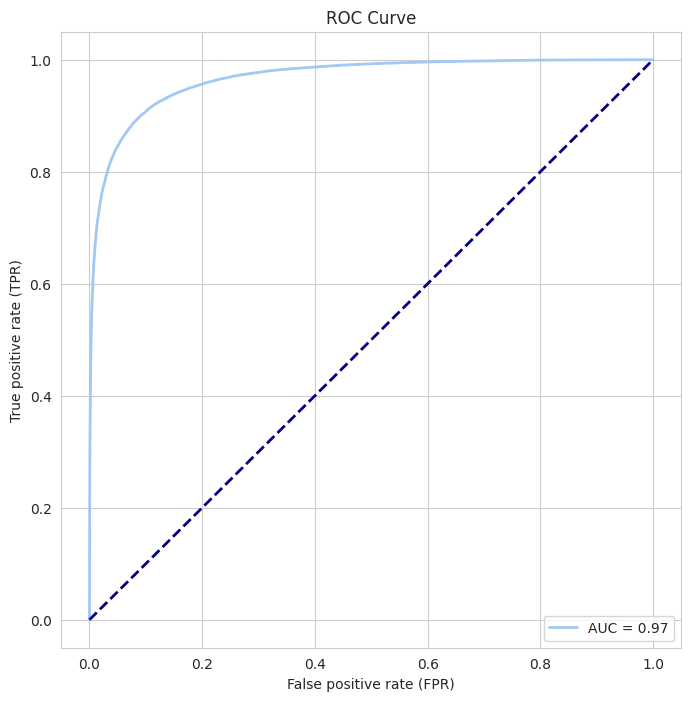

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

#Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

#Calculate Area under the ROC Curve (AUC)
roc_auc = auc(fpr, tpr)

#Plot the ROC Curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

After analyzing both metrics, we observe excellent results on the training set. The model achieves a ROC-AUC of 0.97 and an accuracy score of 0.906, effectively classifying almost all positive cases without a significant loss of accuracy.

It's important to note that we are currently analyzing the training dataset, and as such, these metrics may not be the best indicators of the model's overall performance. However, during the training phase, the validation and training scores were very similar. Therefore, we can reasonably infer that the results on the test dataset will likely be comparable to the observed training performance.

In [34]:
#Preparation of DataFrame of the test data
input_folder = "/kaggle/input/histopathologic-cancer-detection/test/"

test_df = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/sample_submission.csv")
test_df["id"] = input_folder + test_df["id"] + ".tif"

In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Generator of test data
test_datagen = ImageDataGenerator(
    rescale=1./255,
)

#Test flow from DataFrame
test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'id',
    y_col = None,
    target_size = (96, 96),
    batch_size = 512,
    class_mode = None,
    shuffle = False
)

Found 57458 validated image filenames.


In [36]:
#Make the final predictions
predictions = model.predict(test_generator)

113/113 [==============================] - 405s 4s/step


In [37]:
#Save the predictions into the submission DataFrame and format it
submission = test_df.copy()

submission["id"] = submission["id"].str.replace(input_folder, "").str.replace(".tif", "")
submission["label"] = predictions

submission.to_csv("submission_f.csv", index = False)

# Conclusions

In conclusion, the overall objectives of this report were fully accomplished. It was possible to generate a model that effectively classifies whether a patient is positive for a disease or not, minimizing false negatives and avoiding giving inadequate or delayed treatment. Even though the accuracy is around 90% in most cases, the majority of positive cases were correctly classified. Additionally, for a doctor, analyzing all of these images is a very time-consuming task. With the implementation of this model, we can classify more than 200,000 images in less than 11 minutes.

One of the problems that I encountered while designing and training this model was the unnecessary complexity of the network. I tried to add a lot of convolutional layers and avoid MaxPooling because I didn't want to "lose information." This caused overfitting, noise, and some more problems during the model training. Reducing the complexity by decrementing the number of filters, adding a MaxPool on each layer, and incorporating some regularization techniques dramatically improved the training speed and reduced the overall complexity. Additionally, it reduced overfitting and increased the generalization of the model by obtaining a good score on the leaderboard.

In the future, when approaching new projects, I plan to thoroughly analyze the specific problem at hand to gain a deep understanding of it. This will allow me to design a network tailored specifically for that problem, applying the corresponding regularization techniques and dimensionality reduction methods.

**References**

Clinic, C. (2021). Metastasis (Metastatic Cancer): Definition, Biology & Types. Retrieved October 1, 2023, from Cleveland Clinic website: https://my.clevelandclinic.org/health/diseases/22213-metastasis-metastatic-cancer

ROC AUC. (2023). Hands-On Neuroevolution with Python. Retrieved November 8, 2023, from O’Reilly Online Learning website: https://www.oreilly.com/library/view/hands-on-neuroevolution-with/9781838824914/004a5478-2f60-4fcb-b119-b75e9b1612bc.xhtml
